In [1]:
import numpy as np
import pandas as pd
import cv2
import glob
import os
import re
import tensorflow as tf
from os.path import basename
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

/home/sachin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
images=[]
for img in glob.glob("/home/sachin/Downloads/Datasets/leaf_class/train/**/*.png"):
    images.append(img)

In [3]:
images[0]

'/home/sachin/Downloads/Datasets/leaf_class/train/Charlock/846db9b8a.png'

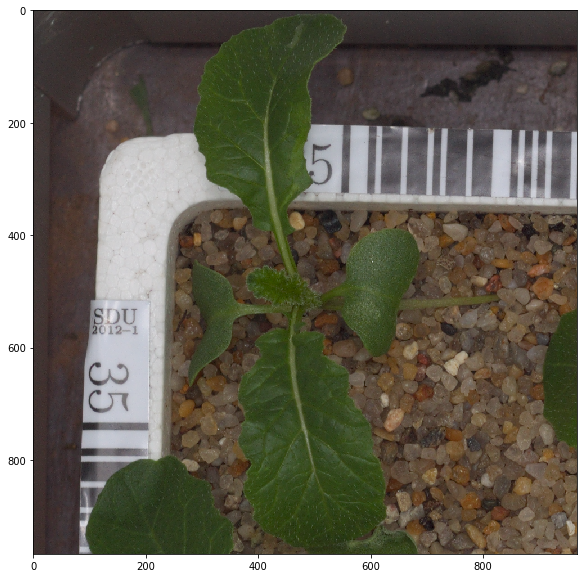

In [4]:
img_temp=cv2.imread(images[0])
img=cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)

In [5]:
#get the label from the pathname
y_labels=[]
for img_name in images:
    y_labels.append(re.sub(r'\s', '', img_name).split('/')[-2])
y_labels=np.array(y_labels)


In [6]:
images[0].split('/')[-2]

'Charlock'

In [7]:
y_labels

array(['Charlock', 'Charlock', 'Charlock', ...,
       'Small-floweredCranesbill', 'Small-floweredCranesbill',
       'Small-floweredCranesbill'], dtype='<U24')

In [8]:
# function to convert labels in to numbers
def names_to_numbers(y_target):
    unq=np.unique(y_target)
    n=len(unq)
    numbers = list(range(0, n))
    y_dict=dict(zip(unq,numbers))
    y_true=[]
    for label in y_target:
        n=y_dict[label]
        y_true.append(n)
    return y_true
labels=names_to_numbers(y_labels)

In [9]:
#function for mapping feartures and labels
def parse_function(image_name, label):
    image_string = tf.read_file(image_name)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)

    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize_images(image, [224,224])
    
    return image, label

In [10]:
X_train, X_test, y_train, y_test = train_test_split( images, labels, test_size=0.2)

In [11]:
batch_size=32

In [12]:
#creating tensorflow datasets for train data
labels_train=tf.one_hot(y_train,12)
dataset=tf.data.Dataset.from_tensor_slices((X_train,labels_train))
dataset=dataset.map(parse_function)
dataset=dataset.shuffle(buffer_size=100)
dataset=dataset.batch(batch_size)

In [13]:
#iterators for train data
iterator = dataset.make_initializable_iterator()
def train_data():
    x,y = iterator.get_next()
    return x,y

In [14]:
##creating tensorflow datasets for test data
labels_test=tf.one_hot(y_test,12)
dataset_test=tf.data.Dataset.from_tensor_slices((X_test,labels_test))
dataset_test=dataset_test.map(parse_function)
dataset_test=dataset_test.batch(batch_size)

In [15]:
#iterators  for test data
iterator_test = dataset_test.make_initializable_iterator()
def test_data():  
    x,y = iterator_test.get_next()
    return x,y
#boolean to decide train data or test data to the module
a = tf.placeholder(tf.bool)  
x,y= tf.cond(tf.equal(a, tf.constant(True)), lambda:train_data(), lambda:test_data())

In [16]:
conv1=tf.layers.conv2d(x,filters=96,kernel_size=(11,11),strides=4,padding="SAME",activation=tf.nn.relu,name="conv1")
lrn1 = tf.nn.lrn(input=conv1, depth_radius=5, bias=1.0, alpha=0.0001/5.0, beta=0.75); #Normalization layer
pool1_conv1 = tf.layers.max_pooling2d(inputs=lrn1, pool_size=[3, 3], strides=2) #Max Pool Layer

conv2 = tf.layers.conv2d(inputs=pool1_conv1, filters=256, kernel_size=[5, 5], strides=1, padding="same", activation=tf.nn.relu)
lrn2 = tf.nn.lrn(input=conv2, depth_radius=5, bias=1.0, alpha=0.0001/5.0, beta=0.75); #Normalization layer
pool2_conv2 = tf.layers.max_pooling2d(inputs=lrn2, pool_size=[3, 3], strides=2) #Max Pool Layer
#print(pool2_conv2)


conv3 = tf.layers.conv2d(inputs=pool2_conv2, filters=384, kernel_size=[3, 3], strides=1, padding="same", activation=tf.nn.relu)
#print(conv3)


conv4 = tf.layers.conv2d(inputs=conv3, filters=384, kernel_size=[3, 3], strides=1, padding="same", activation=tf.nn.relu)
#print(conv4)


conv5 = tf.layers.conv2d(inputs=conv4, filters=256, kernel_size=[3, 3], strides=1, padding="same", activation=tf.nn.relu)
pool3_conv5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=[3, 3], strides=2, padding="valid") #Max Pool Layer
#print(pool3_conv5)


#FULLY CONNECTED LAYER 1
#fully-connected layers have 4096 neurons each
pool3_conv5_flat = tf.reshape(pool3_conv5, [-1, 6* 6 * 256]) #output of conv block is 6x6x256 therefore, to connect it to a fully connected layer, we can flaten it out
fc1 = tf.layers.dense(inputs=pool3_conv5_flat, units=4096, activation=tf.nn.relu)
#fc1 = tf.layers.conv2d(inputs=pool3_conv5, filters=4096, kernel_size=[6, 6], strides=1, padding="valid", activation=tf.nn.relu) #representing the FCL using a convolution block (no need to do 'pool3_conv5_flat' above)


#FULLY CONNECTED LAYER 2
"""since the output from above is [1x1x4096]"""
fc2 = tf.layers.dense(inputs=fc1, units=4096, activation=tf.nn.relu)
#fc2 = tf.layers.conv2d(inputs=fc1, filters=4096, kernel_size=[1, 1], strides=1, padding="valid", activation=tf.nn.relu)

logits = tf.layers.dense(inputs=fc2, units=12, name="logits_layer")




In [18]:
#Layers/Archi of our tensorflow model
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
loss=tf.reduce_mean(cross_entropy)
optimizer=tf.train.AdamOptimizer(learning_rate=0.0001)
training_op=optimizer.minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


init = tf.global_variables_initializer()
# saver = tf.train.Saver()

In [19]:
batches=len(X_train)/batch_size
batches=int(batches)
epochs=5
print(batches)
batches_test=len(X_test)/batch_size
print(batches_test)
loss_train=[]
accuracy_train=[]

loss_val=[]
accuracy_val=[]

loss_test=[]
accuracy_test=[]

118
29.6875


In [ ]:
with tf.Session() as sess:
    sess.run(init)
    sess.run(iterator_test.initializer)  
    for epoch in range(epochs):
        sess.run(iterator.initializer)
        print("Epoch:",epoch ,"running")
        for batch in range(batches):
            loss,acc,_=sess.run([loss_op,accuracy,training_op],feed_dict={a:True})
            accuracy_train.append(acc)
            loss_train.append(loss)
            if batch%50==0:
                print("batch",batch,"loss:",loss,"accuracy",acc)
                sess.run(iterator_test.initializer) 
                l_v,acc_v=sess.run([loss_op,accuracy],feed_dict={a:False})
                accuracy_val.append(acc_v)
                loss_val.append(l_v)
                print("validation data loss",l_v,"accuracy",acc_v)
print("Training finished")
    
      
   

Epoch: 0 running
batch 0 loss: 2.4820848 accuracy 0.125
validation data loss 2.4843066 accuracy 0.0625
batch 50 loss: 2.3930714 accuracy 0.28125
validation data loss 2.4334645 accuracy 0.1875
batch 100 loss: 1.9685917 accuracy 0.28125
validation data loss 2.1072178 accuracy 0.1875
Epoch: 1 running
batch 0 loss: 1.9215634 accuracy 0.40625
validation data loss 1.838417 accuracy 0.28125
batch 50 loss: 1.7455122 accuracy 0.46875
validation data loss 1.8054776 accuracy 0.28125
batch 100 loss: 1.8485063 accuracy 0.5
validation data loss 1.4676723 accuracy 0.375
Epoch: 2 running
batch 0 loss: 1.7986991 accuracy 0.375
validation data loss 1.4788 accuracy 0.375
batch 50 loss: 1.2234414 accuracy 0.59375
validation data loss 1.1214321 accuracy 0.53125
